# BERT (stopwords not removed)

This version of BERT was run without removing stop words! I assume it should be using 512 token length... since I did not specify? 

In [1]:
# following this tutorial: https://medium.com/@skillcate/detecting-fake-news-with-a-bert-model-9c666e3cdd9b
import re
import tqdm
from nltk.corpus import stopwords
import nltk
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_addons as tfa
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

In [2]:
# read data
df = pd.read_csv("raw_data/fulltrain.csv", names=["labels", "text"])
test_df = pd.read_csv("raw_data/balancedtest.csv", names=["labels", "text"])
df.head()

,labels,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [3]:
from sklearn.model_selection import train_test_split
# transform y into 1 hot vectors
y = pd.get_dummies(df["labels"])
y = np.array(y)
y_test = pd.get_dummies(test_df["labels"])
y_test = np.array(y_test)

X_test = test_df["text"]
X_train, X_val, y_train, y_val = train_test_split(df['text'],y, stratify=df['labels'])
X_train.head(4)

21117    Former Merck Employee Targeted for Harassment,...
26447    The Asian Pivot and the Revolving EmpireHow Am...
10204    Saying that she wants nothing more than for he...
27085    Amazon CIA Cloud Contract and Its Bid to Take ...
Name: text, dtype: object

In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['text'] = df['text'].apply(clean_text)

In [5]:
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(4, activation='softmax', name="output")(l)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-03 00:40:30.624097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-03 00:40:30.624198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-03 00:40:33.137793: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-03 00:40:33.160382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [7]:
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics = [
        "categorical_accuracy", 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
        tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
    ]
)



In [9]:
# fit
with tf.device('/cpu:0'):
    model.fit(X_train, y_train, epochs=2, batch_size = 32)

Epoch 1/2


2023-04-03 00:41:48.970696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   3/1145 [..............................] - ETA: 48:23 - loss: 1.5356 - categorical_accuracy: 0.2917 - precision: 0.3571 - recall: 0.1562 - auc: 0.5721 - f1_score_micro: 0.2917 - f1_score_macro: 0.1415

KeyboardInterrupt: 

In [30]:
model.save('bert_model')

2023-03-30 20:09:09.273221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-30 20:09:21.377468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: bert_model/assets


INFO:tensorflow:Assets written to: bert_model/assets


In [33]:
with tf.device('/cpu:0'):
    results = model.evaluate(X_test, y_test, batch_size=32)
    print('Test loss:', results[0])
    print('Test categorical_accuracy:', results[1])
    print('Test precision:', results[2])
    print('Test recall:', results[3])
    print('Test auc:', results[4])
    print('Test F1 (micro):', results[5])
    print('Test F1 (macro):', results[6])

2023-03-30 23:48:00.616345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 998s 3s/step - loss: 0.5037 - categorical_accuracy: 0.8215 - precision_1: 0.8733 - recall_1: 0.7645 - auc_1: 0.9614 - f1_score_micro: 0.8215 - f1_score_macro: 0.8032
Test loss: 0.5037228465080261
Test categorical_accuracy: 0.8215162754058838
Test precision: 0.8732697367668152
Test recall: 0.7644506096839905
Test auc: 0.9613867998123169
Test F1 (micro): 0.8215162754058838
Test F1 (macro): 0.8032023906707764


In [40]:
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from PIL import Image 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def draw_confusion_matrix(true, preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(
        conf_matx, 
        annot=True, 
        annot_kws={"size": 12},
        fmt='g', 
        cbar=False, 
        cmap="viridis"
    )
    plt.show()

In [38]:
# test on balanced test.csv
test_df = pd.read_csv("raw_data/balancedtest.csv", names=["labels", "text"])

# split into x_test and y_test
x_ftest = test_df['text']

# transform y into one hot vectors
y_ftest = pd.get_dummies(test_df["labels"])
y_ftest = np.array(y_test)



In [39]:
with tf.device('/cpu:0'):
    # predict
    print("START predict")
    test_predictions = model.predict(x_ftest)
    test_result = np.argmax(test_predictions, axis=1)
    print("DONE predict")

    # evaluate
    print("START evaluate")
    test_results = model.evaluate(x_ftest, y_ftest)
    print('Test loss:', test_results[0])
    print('Test categorical_accuracy:', test_results[1])
    print('Test precision:', test_results[2])
    print('Test recall:', test_results[3])
    print('Test auc:', test_results[4])
    print('Test F1 (micro):', test_results[5])
    print('Test F1 (macro):', test_results[6])



START predict


2023-03-31 00:15:36.704931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 236s 2s/step
DONE predict
START evaluate
94/94 [==============================] - 239s 3s/step - loss: 1.1203 - categorical_accuracy: 0.5313 - precision_1: 0.5732 - recall_1: 0.4267 - auc_1: 0.7868 - f1_score_micro: 0.5313 - f1_score_macro: 0.5198
Test loss: 1.1202950477600098
Test categorical_accuracy: 0.531333327293396
Test precision: 0.573219895362854
Test recall: 0.4266666769981384
Test auc: 0.7867598533630371
Test F1 (micro): 0.531333327293396
Test F1 (macro): 0.5198416709899902


NameError: name 'confusion_matrix' is not defined

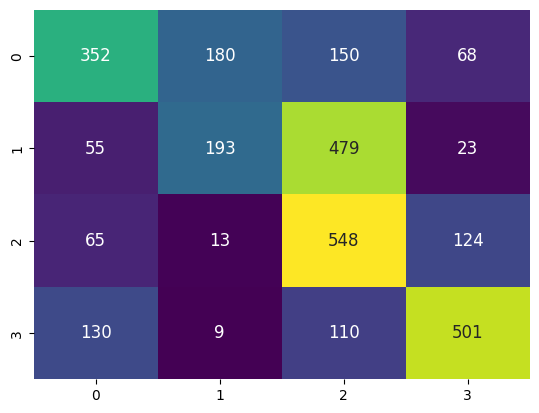

In [41]:
draw_confusion_matrix(np.argmax(y_ftest, axis=1), test_result)

In [46]:
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding TODO: double check for this dataset supposed to be 131926
EMBEDDING_DIM = 300 # embedding dimensions for word vectors


model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable=False,
    name = 'embeddings'))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(128, activation="relu"))
# model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation="softmax"))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 1000, 300)         9386700   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 512)        1140736   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              795600    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 50)               